In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.legendre import leggauss

from ipywidgets import interact
import ipywidgets as widgets 
from matplotlib.collections import PatchCollection
import matplotlib.patches as patches
from matplotlib.pyplot import cm

%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pymuqModeling_ as mm
import pymuqUtilities as mu
import pymuqApproximation as ma

from GaussianPosterior import *
from Convolution import *
import basis


def print_multiset(multiset) :
    print('Multiset ({} indices): '.format(len(multiset.GetAllMultiIndices())))
    for m in multiset.GetAllMultiIndices() : print(m.GetVector(), end=' ')
    print()
    print('Active Multiset ({} indices): '.format(multiset.Size()))
    for i in range(multiset.Size()) : print(multiset.IndexToMulti(i).GetVector(), end=' ')
    print()

In [2]:
x_measurement = np.linspace(-1,1,10)
param  = [.1,.2,.4]
noise = .1
d = len(param)

conv = Convolution(basis=basis.hats, d=d, alpha=1, x_val=x_measurement)
y_measurement = conv.Evaluate([param])[0] + noise*np.random.randn(len(x_measurement))


postr = GaussianPosterior(noise=noise, y_measurement=y_measurement)
graph = mm.WorkGraph()
graph.AddNode(conv, 'model')
graph.AddNode(postr, 'postr')
graph.AddEdge('model', 0, 'postr', 0)
target = graph.CreateModPiece('postr')

In [3]:
class SimpleTarget(mm.PyModPiece):

    def __init__(self, d):
        super(SimpleTarget, self).__init__([d], [1])

    def EvaluateImpl(self, inputs):
        return [[1]]

## Construct the PCE

In [4]:
d = 1
target = SimpleTarget(d)
#model = mm.CosOperator(d)
smolyPCE = ma.AdaptiveSmolyakPCE(target, [ma.LejaQuadrature()]*d, [ma.Legendre()]*d, 'interpolation');

multis = mu.MultiIndexFactory.CreateTotalOrder(d,1)
#multis = mu.MultiIndexFactory.CreateAnisotropic([.5,.1, .05], .8)
print_multiset(multis)

pce = smolyPCE.Compute(multis, {'ShouldAdapt': 0, 'ErrorTol' : 1e-4})
smolyPCE.PrintInfo()

print('Number of Model Evaluations:')
print(smolyPCE.NumEvals())

print('\nEstimated L2 Error:')
print('%0.4e'%smolyPCE.Error())

Multiset (10 indices): 
[0 0 0] [1 0 0] [0 1 0] [0 0 1] [1 0 1] [0 1 1] [0 0 2] [1 1 0] [0 2 0] [2 0 0] 
Active Multiset (4 indices): 
[0 0 0] [0 0 1] [0 1 0] [1 0 0] 


IndexError: vector::_M_range_check: __n (which is 0) >= this->size() (which is 0)

In [ ]:
Number of Model Evaluations:
161

Estimated L2 Error:
2.7748e-01

In [4]:
multis.GetAllMultiIndices()

In [5]:
multis.Size()

12

### Plot the convergence diagnostics

In [9]:
errorHist = smolyPCE.ErrorHistory()
evalHist = smolyPCE.EvalHistory()
timeHist = smolyPCE.TimeHistory()

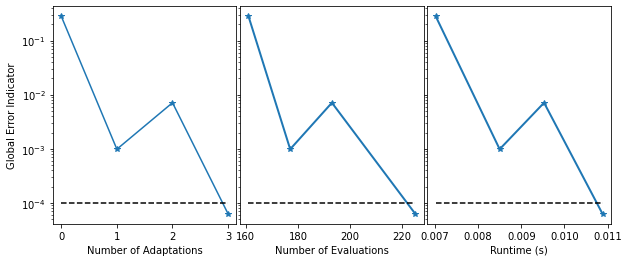

In [10]:
fig, axs = plt.subplots(ncols=3,sharey=True,figsize=(10,4))

axs[0].semilogy(errorHist,'*-')
axs[0].set_ylabel('Global Error Indicator')
axs[0].set_xlabel('Number of Adaptations')
axs[0].semilogy([0, len(errorHist)-1], [options['ErrorTol'],options['ErrorTol']],'--k')

axs[1].semilogy(evalHist, errorHist,'*-',linewidth=2)
axs[1].set_xlabel('Number of Evaluations')
axs[1].semilogy([evalHist[0], evalHist[-1]], [options['ErrorTol'],options['ErrorTol']],'--k')

axs[2].semilogy(timeHist, errorHist,'*-',linewidth=2)
axs[2].semilogy([timeHist[0], timeHist[-1]], [options['ErrorTol'],options['ErrorTol']],'--k')

axs[2].set_xlabel('Runtime (s)')

plt.subplots_adjust(wspace=0.02)
plt.show()

### Plot the model points and Smolyak terms

In [14]:
ptHist = smolyPCE.PointHistory()
termHist = smolyPCE.TermHistory()

In [15]:
colors=cm.tab20(np.linspace(0,1,len(termHist)))

def PlotAdaptation(AdaptIt):

    fig, axs = plt.subplots(ncols=2,figsize=(11,5))

    for it in range(AdaptIt+1):

        pts_x = [pt[0] for pt in ptHist[it]]
        pts_y = [pt[1] for pt in ptHist[it]]
        axs[0].plot(pts_x,pts_y, '.',markersize=14,color=colors[it])
        
        # Create a Rectangle patch
        boxes=[]
        for term in termHist[it]:
            termVec = term.GetVector()
            boxes.append( patches.Rectangle((termVec[0]-0.5,termVec[1]-0.5),1.0,1.0))

        axs[1].add_collection(PatchCollection(boxes, facecolor=colors[it]))
        
    axs[0].set_xlim([-1.1,1.1])
    axs[0].set_ylim([-1.1,1.1])

    axs[0].set_xlabel('$x_1$')
    axs[0].set_ylabel('$x_1$')
    axs[0].set_title('Evaluation Points (Iteration %d)'%AdaptIt)

    axs[1].set_xlim([-0.5,7.5])
    axs[1].set_ylim([-0.5,7.5])

    axs[1].set_ylabel('Order in $x_1$')
    axs[1].set_ylabel('Order in $x_2$')
    axs[1].set_title('Smolyak Terms (Iteration %d)'%AdaptIt)
    

interact(PlotAdaptation, AdaptIt=widgets.IntSlider(min=0, max=len(ptHist)-1, step=1, value=len(ptHist)-1));


interactive(children=(IntSlider(value=5, description='AdaptIt', max=5), Output()), _dom_classes=('widget-inter…

### Plot the polynoial terms in the PCE

In [16]:
polyTerms = pce.Multis()

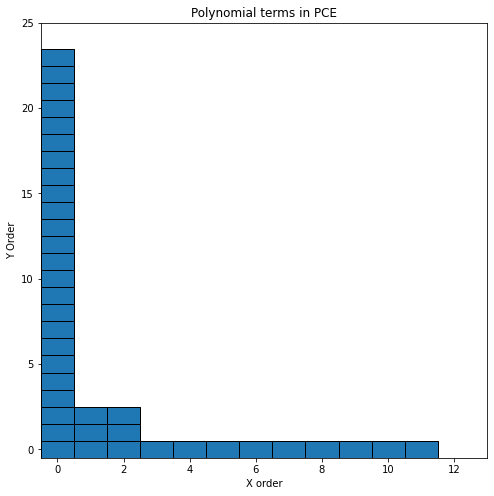

In [17]:
fig = plt.figure(figsize=(8,8))

# A list of rectangular patches.  One for each term
boxes=[]

# Loop over all of the multiindices 
maxOrderX = 0 # 
maxOrderY = 0
for i in range(polyTerms.Size()):
    termVec = polyTerms.at(i).GetVector()
    
    boxes.append( patches.Rectangle((termVec[0]-0.5,termVec[1]-0.5),1.0,1.0))
    
    maxOrderX = np.max([maxOrderX, termVec[0]])
    maxOrderY = np.max([maxOrderY, termVec[1]])

    
plt.gca().add_collection(PatchCollection(boxes,edgecolors='k'))
plt.xlim(-0.5,maxOrderX+2)
plt.ylim(-0.5,maxOrderY+2)

plt.xlabel('X order')
plt.ylabel('Y Order')
plt.title('Polynomial terms in PCE')
plt.show()

## Plot the PCE predictions

Before plotting, we need to evaluate the true model and the PCE surrogate at a grid of points.  These evaluations are completed in the following cell.

In [13]:
numPlot = 50

x = np.linspace(-1,1,numPlot)
X, Y = np.meshgrid(x,x)

trueEvals = np.zeros(X.shape)
pceEvals = np.zeros(X.shape)

for i in range(numPlot):
    for j in range(numPlot):
        pt = [X[i,j],Y[i,j]]
        
        trueEvals[i,j] = model.Evaluate([pt])[0][0]
        pceEvals[i,j] = pce.Evaluate([pt])[0][0]        

The cell below plots the true model evaluations, the PCE evaluations, and the error.  

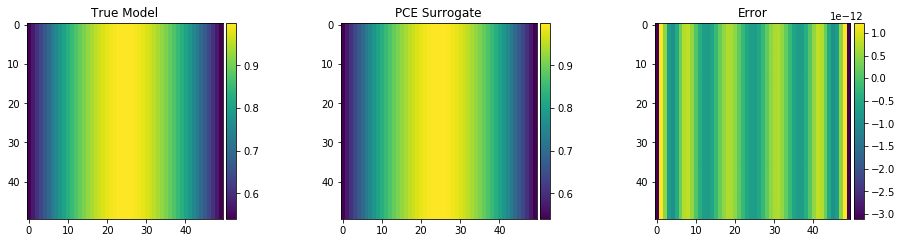

In [14]:
fig, axs = plt.subplots(ncols=3, figsize=(15,7), gridspec_kw={'wspace':0.5})

# Plot the true model
im = axs[0].imshow(trueEvals)
axs[0].set_title('True Model')

divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

# Plot the PCE Surrogate
im = axs[1].imshow(pceEvals)
axs[1].set_title('PCE Surrogate')

divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


im = axs[2].imshow(pceEvals-trueEvals)

axs[2].set_title('Error')
divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()

## Propagate Uncertainty

In [15]:
print('Prediction Mean:')
print(pce.Mean())

print('\nPrediction Variance:')
print(pce.Variance())

print('\nPrediction Covariance:')
print(pce.Covariance())


Prediction Mean:
[0.84147098 0.84147098]

Prediction Variance:
[0.01925094 0.01925094]

Prediction Covariance:
[[1.92509384e-02 1.09585700e-18]
 [1.09585700e-18 1.92509384e-02]]


## Sensitivity analysis

In [16]:
totalSens1 = pce.TotalSensitivity(0)
totalSens2 = pce.TotalSensitivity(1)

print('Total Sensitivities:')
print('  Output 0 wrt parameter 0 = %0.2e'%totalSens1[0])
print('  Output 0 wrt parameter 1 = %0.2e'%totalSens1[1])
print('  Output 1 wrt parameter 0 = %0.2e'%totalSens2[0])
print('  Output 1 wrt parameter 1 = %0.2e'%totalSens2[1])

print('\nAll Total Sensitivities:')
print(pce.TotalSensitivity())

mainEffects1 = pce.SobolSensitivity(0)
mainEffects2 = pce.SobolSensitivity(1)
print('\nFirst Order Sobol Indices:')
print('  Output 0 wrt parameter 0 = %0.2e'%mainEffects1[0])
print('  Output 0 wrt parameter 1 = %0.2e'%mainEffects1[1])
print('  Output 1 wrt parameter 0 = %0.2e'%mainEffects2[0])
print('  Output 1 wrt parameter 1 = %0.2e'%mainEffects2[1])

Total Sensitivities:
  Output 0 wrt parameter 0 = 1.00e+00
  Output 0 wrt parameter 1 = 1.39e-29
  Output 1 wrt parameter 0 = 1.46e-29
  Output 1 wrt parameter 1 = 1.00e+00

All Total Sensitivities:
[[1.00000000e+00 1.46011825e-29]
 [1.38826284e-29 1.00000000e+00]]

First Order Sobol Indices:
  Output 0 wrt parameter 0 = 1.00e+00
  Output 0 wrt parameter 1 = 1.36e-29
  Output 1 wrt parameter 0 = 1.44e-29
  Output 1 wrt parameter 1 = 1.00e+00
